# The Sigmoid CV Model

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
import plotly.graph_objects as go
import pandas as pd
import patsy as pt

from yeastdnnexplorer.ml_models.sigmoid_modeling import GeneralizedLogisticModel
from yeastdnnexplorer.ml_models.lasso_modeling import generate_modeling_data, stratification_classification, stratified_cv_modeling

## The Sigmoid Function

The `sigmoid()` function takes the following arguments:

- The observations as a model matrix, where the first column is a constant vector
- Upper Asymptote: The upper bound of the sigmoid curve.
- Lower Asymptote: The lower bound of the sigmoid curve.
- Coefficients (B): The coefficients of the linear combination of input variables
that will control the shape of the sigmoid curve.

$$
Y(X) = \frac{right\_asymptote - left\_asymptote}{1 + e^{- X \cdot B }} + left\_asymptote
$$

This is the base model which is used for fitting the data.

## Fitting the Sigmoid Model to Data

The `GeneralizedLogisticModel` class is used to actually fit the sigmoid parameters to
data. The objective function used is the L-1 regularization of the least squares problem:

$$
\hat{B} = \arg\min_{B} \left( \| y - \hat{y} \|_2^2 + \alpha \|B\|_1 \right)
$$

Where:
- $ y $ is the vector of actual response values (target values).
- $ \hat{y} $ is the vector of predicted response values.
- $ B $ is the vector of coefficients from the sigmoid model described above.
- $ \alpha $ is the regularization parameter that controls the strength of the L-1 penalty.

To accomplish this, the `fit()` function which is called will search over a grid of alphas, and perform stratified cross-validation for each value of alpha to determine the model with the lowest corresponding average MSE. Once the optimal value of alpha is found, the final sigmoid model is then trained on the full dataset and returned. This essentially mirrors the LassoCV object provided by sklearn.


Now let's walk through the process of initializing and training a `GeneralizedLogisticModel` object. First, we will access the binding/response data corresponding to our TF of interest.

In [3]:
tf_of_interest = "CBF1"

# accessing the data - this should correspond to a viable file path containing data on your device.
response_df = pd.read_csv("/Users/ericjia/Downloads/response_brent_nf_cc_mcisaac_oe_20241231.csv", index_col=0)
predictors_df = pd.read_csv("/Users/ericjia/Downloads/predictors_brent_nf_cc_mcisaac_oe_20241231.csv", index_col=0)

# get the relevant binding and response data for your TF
Y, X = generate_modeling_data(tf_of_interest, response_df, predictors_df, drop_intercept=False)

# instantiate the sigmoidcv model object
sigmoidcv = GeneralizedLogisticModel()

# obtain the stratified folds for model training - see lasso_modeling source code for further details
stratification_classes = stratification_classification(
        X["CBF1"].squeeze(), Y.squeeze()
    )

# train the sigmoidcv model - stratified_cv_modeling is a function that handles training using stratified folds - see lasso_modeling source code for further details
fitted_sigmoidcv_model = stratified_cv_modeling(Y, X, stratification_classes, sigmoidcv)


Warning encountered during stratified k-fold split: The least populated class in y has only 1 members, which is less than n_splits=4.


After training the model, we can view relevant metrics below:

In [4]:
fitted_sigmoidcv_model.r_squared

0.13670199287159013

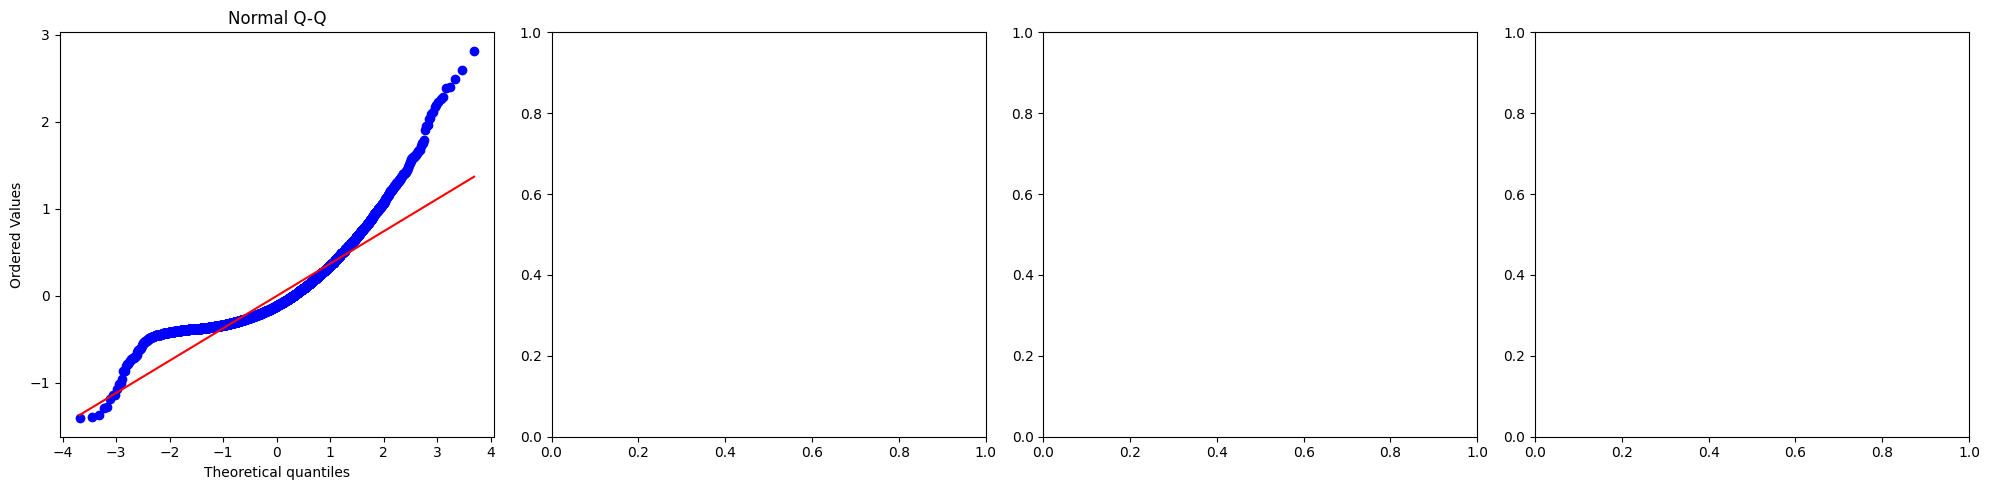

In [6]:
fitted_sigmoidcv_model.plot()

In [8]:
# WARNING: this cell takes fairly long to run on a local device (~ hours) 
# I would recommend running this on a compute cluster if possible
# #fitted_sigmoidcv_model.summary()